In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.morphology as morph
from scipy.ndimage import correlate
from matplotlib.patches import Circle
from operator import add

In [2]:
def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

In [3]:
dsize = 3,64,64
bg = 1 + np.random.randn(*dsize) 
#bg = np.ones(dsize)
cell_pos = [(20,20),(40,40)]
cell_bl = (10, 7.5, 5.625), (30, 22.5, 16.875)
cell_fluc = (10, 7.5 * 2, 5.625 * 1), (0,0,0)
rad = 9
cells_raw = np.zeros(bg.shape)
cells_bl = np.zeros(bg.shape)
for tind in range(cells_raw.shape[0]):
    for cind, cp in enumerate(cell_pos):
        cells_raw[(tind,*cp)] = cell_bl[cind][tind] + cell_fluc[cind][tind]
        cells_bl[(tind,*cp)] = cell_bl[cind][tind]
    cells_raw[tind] = correlate(cells_raw[tind], morph.disk(rad))
    cells_bl[tind] = correlate(cells_bl[tind], morph.disk(rad))
    
shifts = [(0,0), (0,6) ,(0,12)]

cells_obs = cells_raw + bg
cells_bl += bg.mean()
cells_dff = (cells_obs - cells_bl) / (cells_bl)

cells_shifted = cells_obs.copy()
for ind, s in enumerate(shifts):
    cells_shifted[ind] = np.roll(cells_obs[ind], shift=s,axis=(0,1))

dsk = morph.disk(rad)
roi_pts = np.where(dsk)[0] - dsk.shape[0]//2, np.where(dsk)[1] - dsk.shape[1]//2    
roi_coords = [tuple(map(add, roi_pts, pos)) for pos in cell_pos]

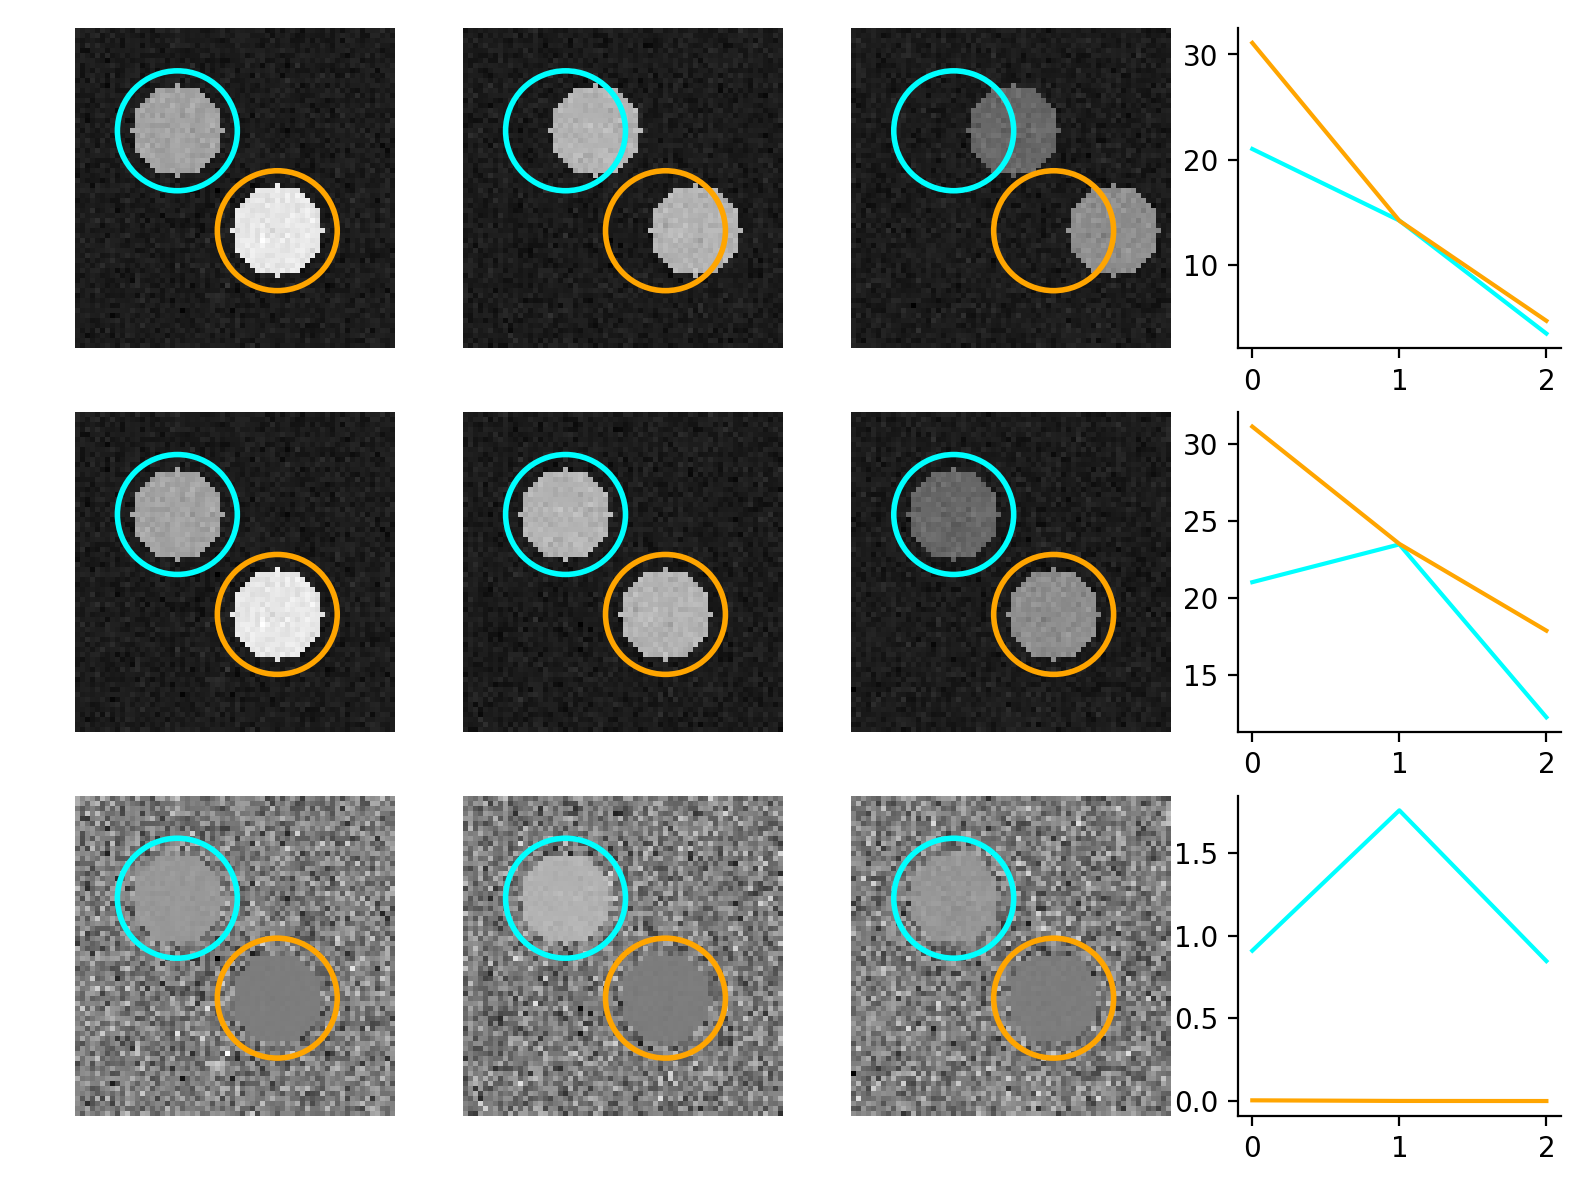

In [4]:
fig, axs = plt.subplots(ncols=1 + cells_raw.shape[0], nrows=3, dpi=200, figsize=(8 * 1.2, 6 * 1.2))
[ax.axis('off') for ax in axs[:,:-1].ravel()]
cmap = 'gray'
colors = ['cyan','orange']
rois = [Circle(pos, radius=rad + 3, fill=False, edgecolor=colors[indp], linewidth=2) for indp, pos in enumerate(cell_pos)]
for t in range(cells_raw.shape[0]):
    axs[0][t].imshow(cells_shifted[t], cmap=cmap, clim=(cells_obs.min(), cells_obs.max()))    
    axs[1][t].imshow(cells_obs[t], cmap=cmap, clim=(cells_obs.min(), cells_obs.max()))    
    axs[2][t].imshow((cells_dff)[t], cmap=cmap, clim=(cells_dff.min(), cells_dff.max()))

[ax.add_patch(Circle(r.center, r.radius, fill=r.fill, edgecolor=r.get_edgecolor(), linewidth=r.get_linewidth())) for r in rois for ax in axs[:,:-1].ravel()];

[axs[0][-1].plot(cells_shifted[(slice(None), *rc)].mean(1), color=colors[ind]) for ind, rc in enumerate(roi_coords)];
[axs[1][-1].plot(cells_obs[(slice(None), *rc)].mean(1), color=colors[ind]) for ind, rc in enumerate(roi_coords)];
[axs[2][-1].plot(cells_dff[(slice(None), *rc)].mean(1), color=colors[ind]) for ind, rc in enumerate(roi_coords)];

[axs_format(ax) for ax in axs[:,-1]]
plt.savefig('/groups/ahrens/ahrenslab/davis/thesis/baseline_motion_cartoon.pdf')

## Make a time series demo of the downsampling idea

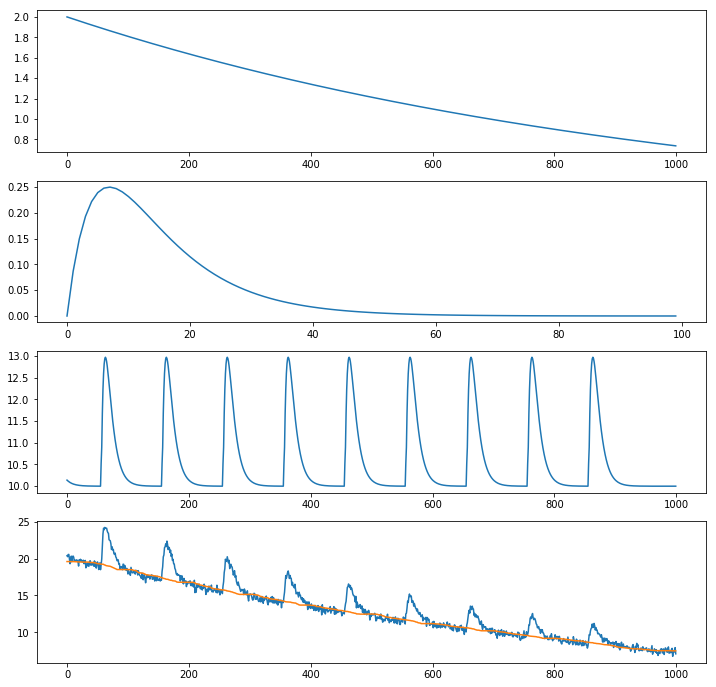

In [5]:
fig, axs = plt.subplots(nrows=4, figsize=(12,12))
from fish.image.vol import baseline
np.random.seed(0)
t = np.linspace(0, 1, 1000)
sample_baseline = np.exp(-t) * 2
kern_t = np.linspace(0, 1, 100)
a,b = -10,-20
spike_kern = np.exp(a * kern_t) - np.exp(b * kern_t)

n_reps = 10
spikes = (np.random.randint(0, 60, t.shape[0] // n_reps) == 3).astype('int')
spikes = np.tile(spikes, n_reps + 1)[:t.shape[0]]
activity = 10 + (6 * np.convolve(spikes, spike_kern, mode='same'))
noise = np.random.randn(*activity.shape) * .3 
observed = (activity * sample_baseline) + noise
axs[0].plot(sample_baseline)
axs[1].plot(spike_kern)
axs[2].plot(activity)
bl_est = baseline(observed, 150, 40)
axs[3].plot(observed)
axs[3].plot(bl_est)

In [13]:
from scipy.ndimage.filters import percentile_filter

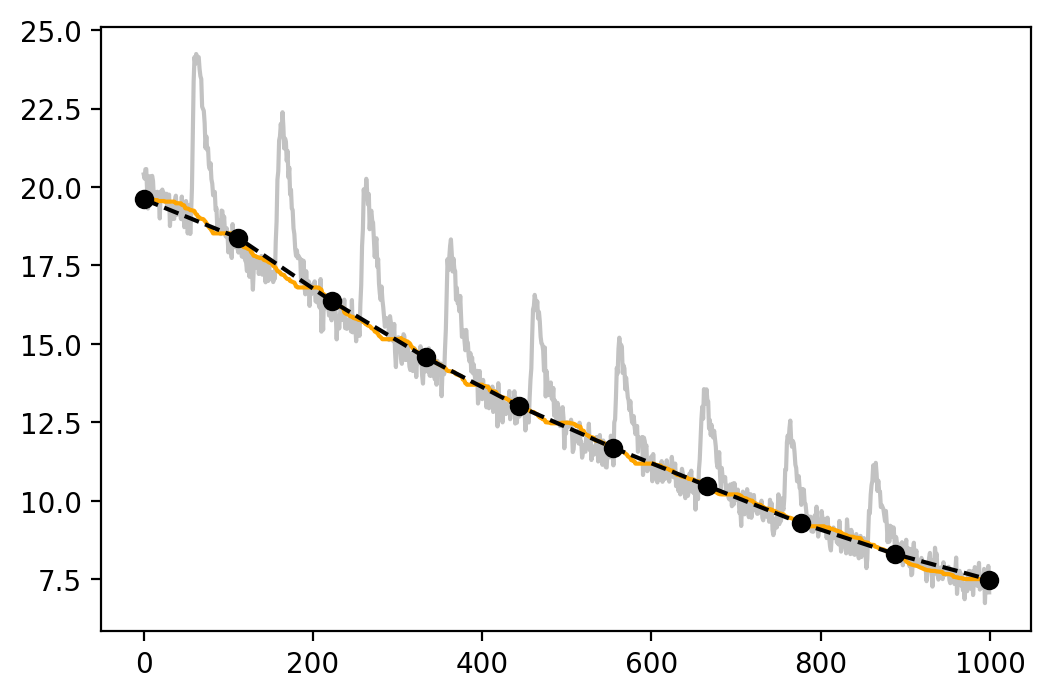

In [26]:
fig, axs=plt.subplots(dpi=200)
axs.plot(observed, alpha=.8, color=(.7,.7,.7))
axs.plot(bl_est, color='orange')
kf = np.linspace(0, bl_est.shape[0]-1, 10).astype('int')
axs.plot(kf, bl_est[kf],'o--', color='k')